# New York City Taxi Trip Duration – Exploratory Data Analysis (EDA)

This project focuses on predicting the **total duration of taxi trips** in New York City.  
We begin by exploring and analyzing the dataset (`train.csv`) to uncover key patterns, distributions, and relationships that will support accurate modeling.

## Importing Libraries

In [1]:
!pip install geopy geographiclib pyproj
import pyproj
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic

# Data Overview

In [1]:
# Load the training data
data = pd.read_csv(f'data/train.csv')

NameError: name 'pd' is not defined

In [3]:
data.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2793718,2,2016-06-08 07:36:19,1,-73.985611,40.735943,-73.980331,40.760468,N,1040
1,id3485529,2,2016-04-03 12:58:11,1,-73.978394,40.764351,-73.991623,40.749859,N,827
2,id1816614,2,2016-06-05 02:49:13,5,-73.989059,40.744389,-73.973381,40.748692,N,614
3,id1050851,2,2016-05-05 17:18:27,2,-73.990326,40.731136,-73.991264,40.748917,N,867
4,id0140657,1,2016-05-12 17:43:38,4,-73.789497,40.646675,-73.987137,40.759232,N,4967


### Data columns
###### id : a unique identifier for each trip 
###### vendor_id : a code indicating the provider associated with the trip record
###### pickup_datetime : date and time when the meter was engaged
###### dropoff_datetime : date and time when the meter was disengaged
###### passenger_count : the number of passengers in the vehicle (driver entered value)
###### pickup_longitude : the longitude where the meter was engaged
###### pickup_latitude : the latitude where the meter was engaged
###### dropoff_longitude : the longitude where the meter was disengaged
###### dropoff_latitude : the latitude where the meter was disengaged
###### store_and_fwd_flag : This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have ###### a connection to the server  Y=store and forward; N=not a store and forward trip
###### trip_duration : duration of the trip in seconds

In [4]:
data.shape

(1000000, 10)

In [6]:
data.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration'],
      dtype='object')

In [7]:
data.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

# Data Exploration and Feature Engineering¶

In [8]:
# Basic statistical summary
data.describe().T

,count,mean,std,min,25%,50%,75%,max
vendor_id,1000000.0,1.534793,0.498788,1.000000,1.000000,2.000000,2.000000,2.000000e+00
passenger_count,1000000.0,1.665353,1.315723,0.000000,1.000000,1.000000,2.000000,7.000000e+00
pickup_longitude,1000000.0,-73.973475,0.065404,-121.933342,-73.991852,-73.981728,-73.967346,-6.133553e+01
pickup_latitude,1000000.0,40.750947,0.033745,34.359695,40.737372,40.754131,40.768379,5.188108e+01
dropoff_longitude,1000000.0,-73.973421,0.065432,-121.933304,-73.991341,-73.979767,-73.963036,-6.133553e+01
dropoff_latitude,1000000.0,40.751829,0.035782,34.359695,40.735928,40.754551,40.769833,4.392103e+01
trip_duration,1000000.0,954.884971,3882.070116,1.000000,397.000000,662.000000,1074.000000,2.227612e+06


In [9]:
# Check for missing values
data.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [10]:
# Check for duplicates
data.duplicated().sum()

0

In [11]:
time_by_hours = (data['trip_duration']  / 3600 ).copy()
time_by_minutes = (data['trip_duration']  / 60 ).copy()

# Summary statistics for trip duration in minutes
print('Number of Zeros:',(time_by_hours == 0).sum())
print('Min value: ',time_by_minutes.min(),'Mintues') 
print('Max : ',time_by_minutes.max(),'Mintues') 
print('Mean : ',time_by_minutes.mean()) 
print('Median : ',time_by_minutes.median()) 

percentage =( (time_by_hours > 2).sum() / time_by_hours.count()) * 100
print('Number of trips that has more than 2 hours :',(time_by_hours > 2).sum(),f' Percentage : {percentage}')

time_by_hours[time_by_hours > 2].sort_values(ascending=False).head(10)

Number of Zeros: 0
Min value:  0.016666666666666666 Mintues
Max :  37126.86666666667 Mintues
Mean :  15.914749516666676
Median :  11.033333333333333
Number of trips that has more than 2 hours : 1548  Percentage : 0.1548


778846    618.781111
947456     23.997778
146031     23.997500
529779     23.997222
524816     23.995833
222751     23.993611
420317     23.991389
500438     23.991389
959782     23.990833
76874      23.990556
Name: trip_duration, dtype: float64

We observe some unrealistic values in trip duration, such as trips lasting up to 25 days. These clearly need to be addressed, so we will start cleaning the dataset.

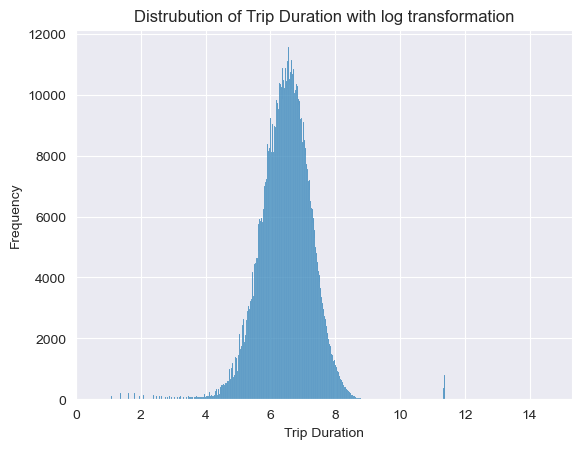

In [12]:
data['log_trip_duration'] = np.log1p(data['trip_duration'])
sns.histplot(data['log_trip_duration'])
plt.title('Distrubution of Trip Duration with log transformation')
plt.xlabel('Trip Duration')
plt.ylabel('Frequency')
plt.show()

Analysis shows that the majority of trips have a duration of less than one hour.

In [13]:
# Freuency of trips 0-2 hours 
labels = []
for i in range(0,125,15):
    labels.append(i * 60)
    
print('Number of trips between (i : i + 15) Mintues.')
for i in labels:
    print(f'{(i / 60):.0f} : {((i / 60)+ 15):.0f}','  ',((data['trip_duration'] >= i) &  (data['trip_duration'] < i + 900) ).sum())

Number of trips between (i : i + 15) Mintues.
0 : 15    663841
15 : 30    258672
30 : 45    54148
45 : 60    14963
60 : 75    4764
75 : 90    1502
90 : 105    434
105 : 120    128
120 : 135    42


# Time Analysis

In [14]:
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['month'] = data['pickup_datetime'].dt.month
data['day'] = data['pickup_datetime'].dt.day
data['quarter'] = data['pickup_datetime'].dt.quarter
data['minute'] = data['pickup_datetime'].dt.minute
data['hour'] = data['pickup_datetime'].dt.hour
data['day_name'] = data['pickup_datetime'].dt.day_name()


def day_period(hour):
    if 0 <= hour < 6:
        return 'Night'
    elif 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:  # 18 <= hour < 24
        return 'Evening'

data['day_period'] = data['hour'].apply(day_period)
season = ['Winter','Spring','Summer','Autumn']


def month_to_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"

data['season'] = data['month'].apply(month_to_season)

data['weekend'] = np.where(data['pickup_datetime'].dt.weekday >= 5, 1, 0)


C:\Users\20109\AppData\Local\Temp\ipykernel_5632\2712451020.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data,x='day_name',order=order,palette='mako')


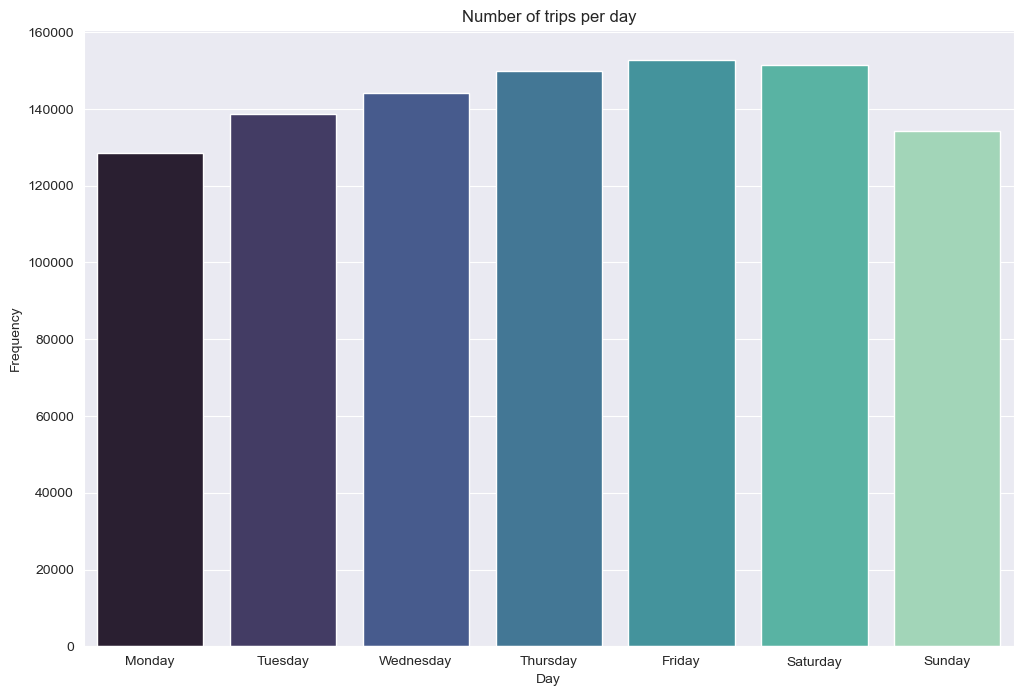

In [15]:
plt.figure(figsize=(12,8))
order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
sns.countplot(data=data,x='day_name',order=order,palette='mako')
plt.xlabel('Day')
plt.ylabel('Frequency')
plt.title('Number of trips per day')
plt.show()

C:\Users\20109\AppData\Local\Temp\ipykernel_5632\706780202.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data,x='season',palette='mako')


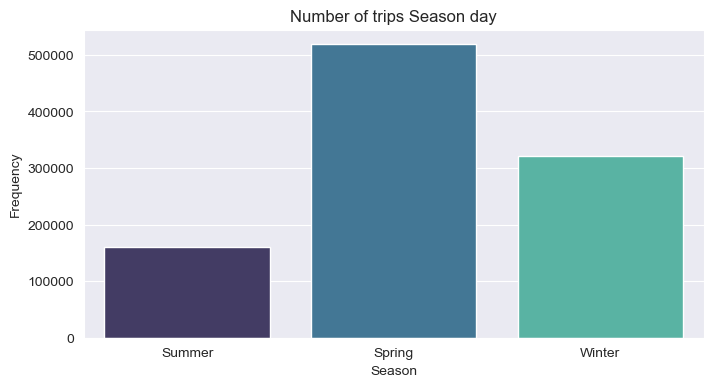

In [16]:
plt.figure(figsize=(8,4))
sns.countplot(data=data,x='season',palette='mako')
plt.xlabel('Season')
plt.ylabel('Frequency')
plt.title('Number of trips Season day')
plt.show()

C:\Users\20109\AppData\Local\Temp\ipykernel_5632\3417766348.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data,x='month',palette='mako')


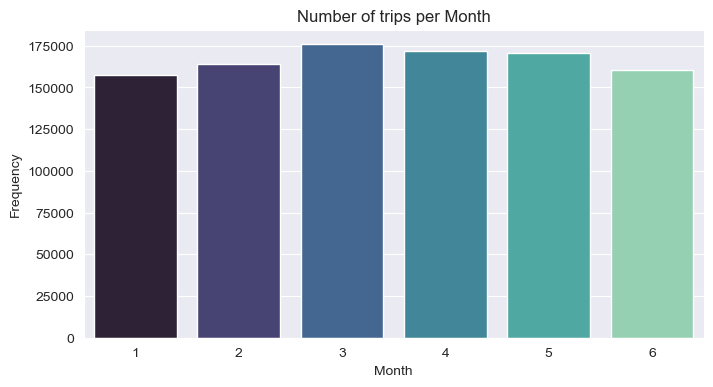

In [17]:
plt.figure(figsize=(8,4))
sns.countplot(data=data,x='month',palette='mako')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.title('Number of trips per Month')
plt.show()

C:\Users\20109\AppData\Local\Temp\ipykernel_5632\3530893325.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data,x='day_period',palette='rocket')


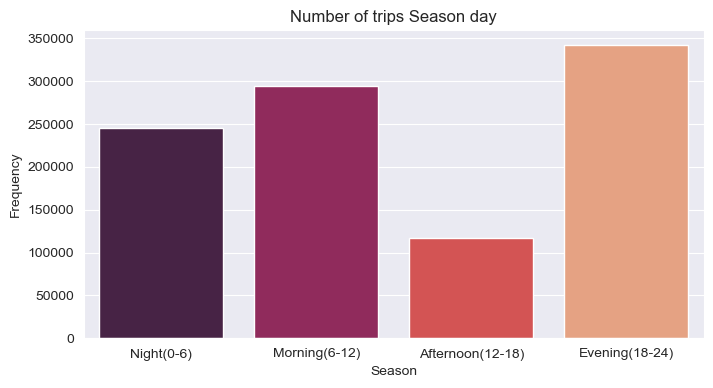

In [18]:
plt.figure(figsize=(8,4))
label = ['Night(0-6)','Morning(6-12)','Afternoon(12-18)','Evening(18-24)']
sns.countplot(data=data,x='day_period',palette='rocket')
plt.xticks(ticks=range(len(label)),labels=label)
plt.xlabel('Season')
plt.ylabel('Frequency')
plt.title('Number of trips Season day')
plt.show()

In [19]:
data.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration',
       'log_trip_duration', 'month', 'day', 'quarter', 'minute', 'hour',
       'day_name', 'day_period', 'season', 'weekend'],
      dtype='object')

C:\Users\20109\AppData\Local\Temp\ipykernel_5632\98656716.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data['pickup_datetime'].dt.hour,palette='cividis')


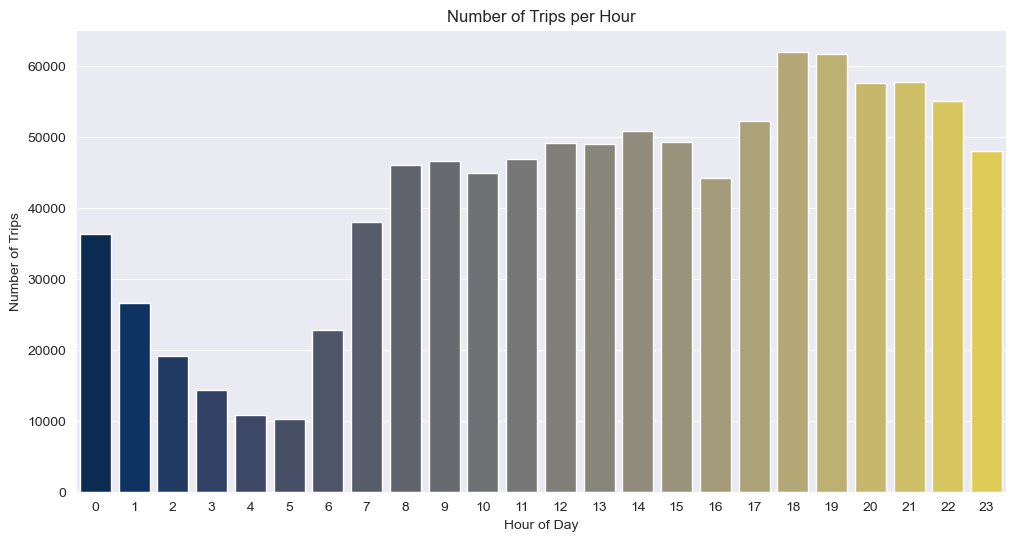

In [20]:
plt.figure(figsize=(12,6)) 
sns.countplot(x=data['pickup_datetime'].dt.hour,palette='cividis')
plt.xlabel("Hour of Day")
plt.ylabel("Number of Trips")
plt.title('Number of Trips per Hour')
plt.show()


In [99]:
hour_counts = data['pickup_datetime'].dt.hour.value_counts()
mean= hour_counts.mean()
filtered = hour_counts[hour_counts > mean]
rush_hours = (filtered.index).tolist()
print(mean)
rush_hours

41481.833333333336


[18, 19, 21, 20, 22, 17, 14, 15, 12, 13, 23, 11, 9, 8, 10, 16]

In [22]:
data['is_rush_hour'] = np.where(data['hour'].isin(rush_hours),1,0)
data['is_rush_hour'] 

0         0
1         1
2         0
3         1
4         1
         ..
999995    1
999996    1
999997    0
999998    1
999999    1
Name: is_rush_hour, Length: 1000000, dtype: int32

In [23]:
data.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,...,month,day,quarter,minute,hour,day_name,day_period,season,weekend,is_rush_hour
0,id2793718,2,2016-06-08 07:36:19,1,-73.985611,40.735943,-73.980331,40.760468,N,1040,...,6,8,2,36,7,Wednesday,Morning,Summer,0,0
1,id3485529,2,2016-04-03 12:58:11,1,-73.978394,40.764351,-73.991623,40.749859,N,827,...,4,3,2,58,12,Sunday,Afternoon,Spring,1,1
2,id1816614,2,2016-06-05 02:49:13,5,-73.989059,40.744389,-73.973381,40.748692,N,614,...,6,5,2,49,2,Sunday,Night,Summer,1,0
3,id1050851,2,2016-05-05 17:18:27,2,-73.990326,40.731136,-73.991264,40.748917,N,867,...,5,5,2,18,17,Thursday,Afternoon,Spring,0,1
4,id0140657,1,2016-05-12 17:43:38,4,-73.789497,40.646675,-73.987137,40.759232,N,4967,...,5,12,2,43,17,Thursday,Afternoon,Spring,0,1


C:\Users\20109\AppData\Local\Temp\ipykernel_5632\1362427772.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data,x='vendor_id',palette='inferno')


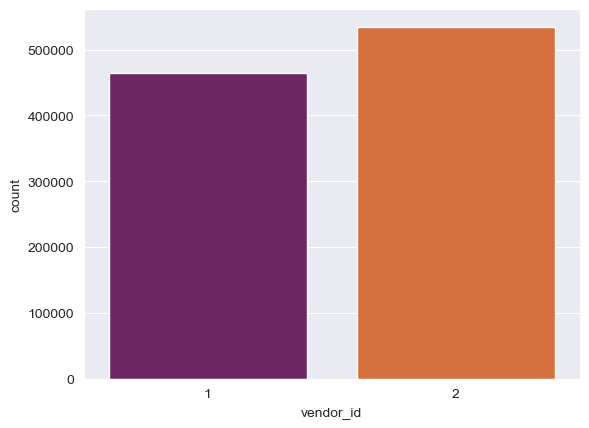

In [24]:
# now we will start looking for exploring vendor_id , passenger count affect on target
sns.countplot(data=data,x='vendor_id',palette='inferno')
plt.show()

# Exploring the relation between features and target

<Axes: >

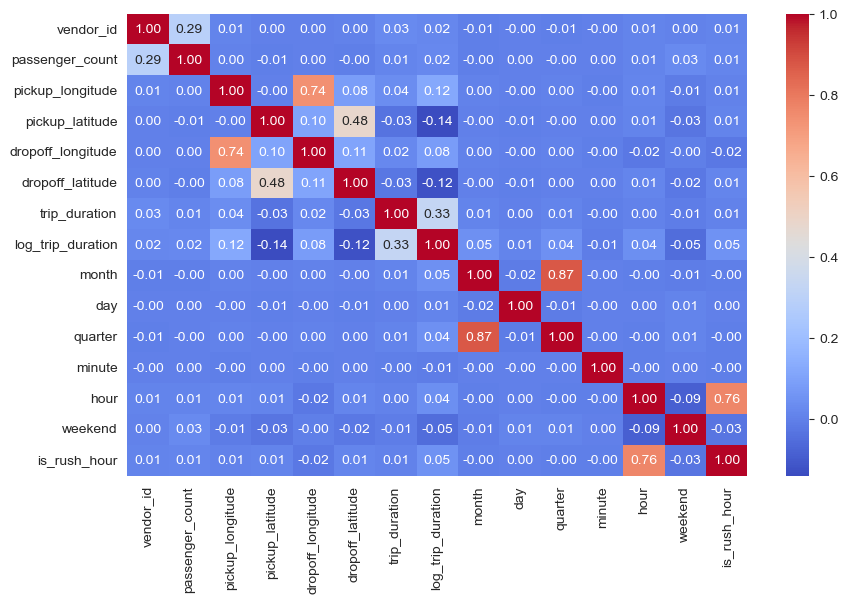

In [25]:
corr = data.corr(numeric_only=True)
plt.figure(figsize=(10,6))
sns.heatmap(corr,annot=True,  cmap="coolwarm", fmt=".2f")

C:\Users\20109\AppData\Local\Temp\ipykernel_5632\2572159608.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data,x='vendor_id',y='log_trip_duration',palette='magma')


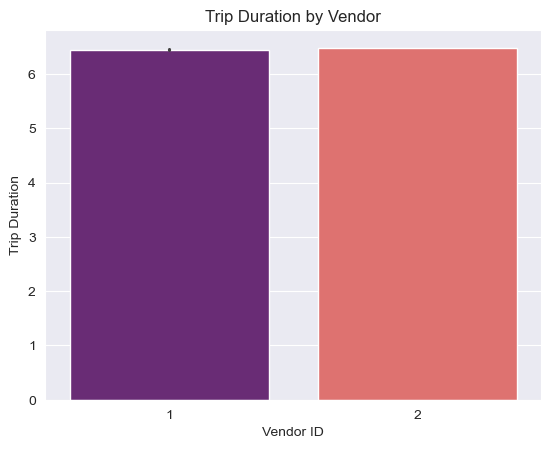

Mean Trip Time for each vendor
vendor_id
1     835.168151
2    1059.024522
Name: trip_duration, dtype: float64
After log transformation
vendor_id
1    6.728830
2    6.966047
Name: trip_duration, dtype: float64


In [26]:
sns.barplot(data=data,x='vendor_id',y='log_trip_duration',palette='magma')
plt.xlabel('Vendor ID')
plt.ylabel('Trip Duration')
plt.title('Trip Duration by Vendor')
plt.show()
avg = data.groupby('vendor_id')['trip_duration'].mean()
print('Mean Trip Time for each vendor')
print(avg)
print('After log transformation')
print(np.log1p(avg))

We can see that the mean trip duration for each vendor is nearly the same.

In [27]:
vd_1 = (data['vendor_id'][(data['trip_duration']  / 3600 ) > 2 ] == 1).sum()
vd_2 = (data['vendor_id'][(data['trip_duration']  / 3600 ) > 2 ] == 2).sum()
sum = (vd_1 + vd_2)
percentage =  (vd_2 / sum) * 100
percentage

96.64082687338501

Most of the outliers appear to be associated with vendor 2.

C:\Users\20109\AppData\Local\Temp\ipykernel_5632\3268655235.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data,x = 'passenger_count',y ='log_trip_duration',palette='viridis',order=sorted(data['passenger_count'].unique()))


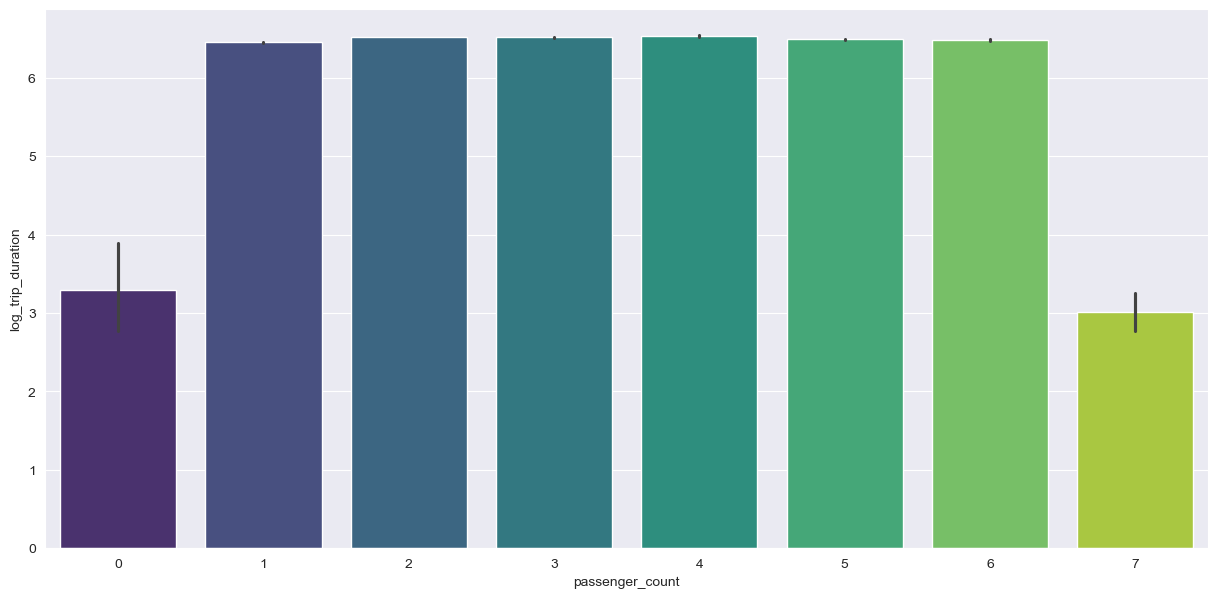

In [28]:
# We will see  the effect of passenger count on trip duration
plt.figure(figsize=(15,7))
sns.barplot(data=data,x = 'passenger_count',y ='log_trip_duration',palette='viridis',order=sorted(data['passenger_count'].unique()))
plt.show()

In [29]:
avg = data.groupby('passenger_count')['trip_duration'].mean()
print('Avgerage trip duration per passenger count')
print(avg)

Avgerage trip duration per passenger count
passenger_count
0     184.789474
1     925.023671
2     996.547652
3    1030.274651
4    1053.786055
5    1072.365526
6    1071.311894
7      20.000000
Name: trip_duration, dtype: float64


In [30]:
data['passenger_count'].value_counts()

passenger_count
1    708628
2    143907
5     53635
3     41012
6     33287
4     19491
0        38
7         2
Name: count, dtype: int64

We observe that there are entries with 0 passengers, which is not valid.

C:\Users\20109\AppData\Local\Temp\ipykernel_5632\4133021523.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data,x='vendor_id',y='log_trip_duration',palette='inferno')


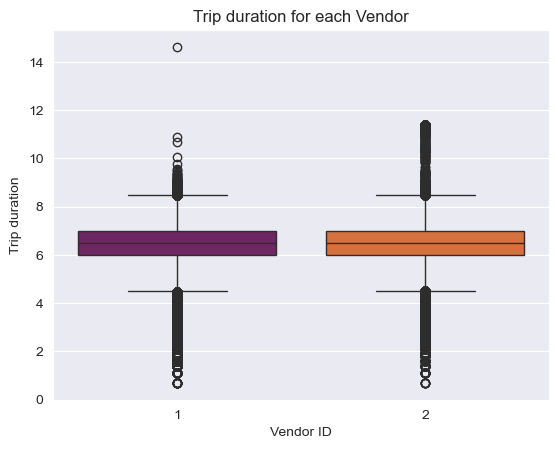

In [31]:
sns.boxplot(data=data,x='vendor_id',y='log_trip_duration',palette='inferno')
plt.xlabel('Vendor ID')
plt.ylabel('Trip duration')
plt.title('Trip duration for each Vendor')
plt.show()

In [32]:
data['trip_duration'].sort_values(ascending=False).head()

778846    2227612
947456      86392
146031      86391
529779      86390
524816      86385
Name: trip_duration, dtype: int64

C:\Users\20109\AppData\Local\Temp\ipykernel_5632\2559263123.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data,x='passenger_count',y='log_trip_duration',palette='inferno')


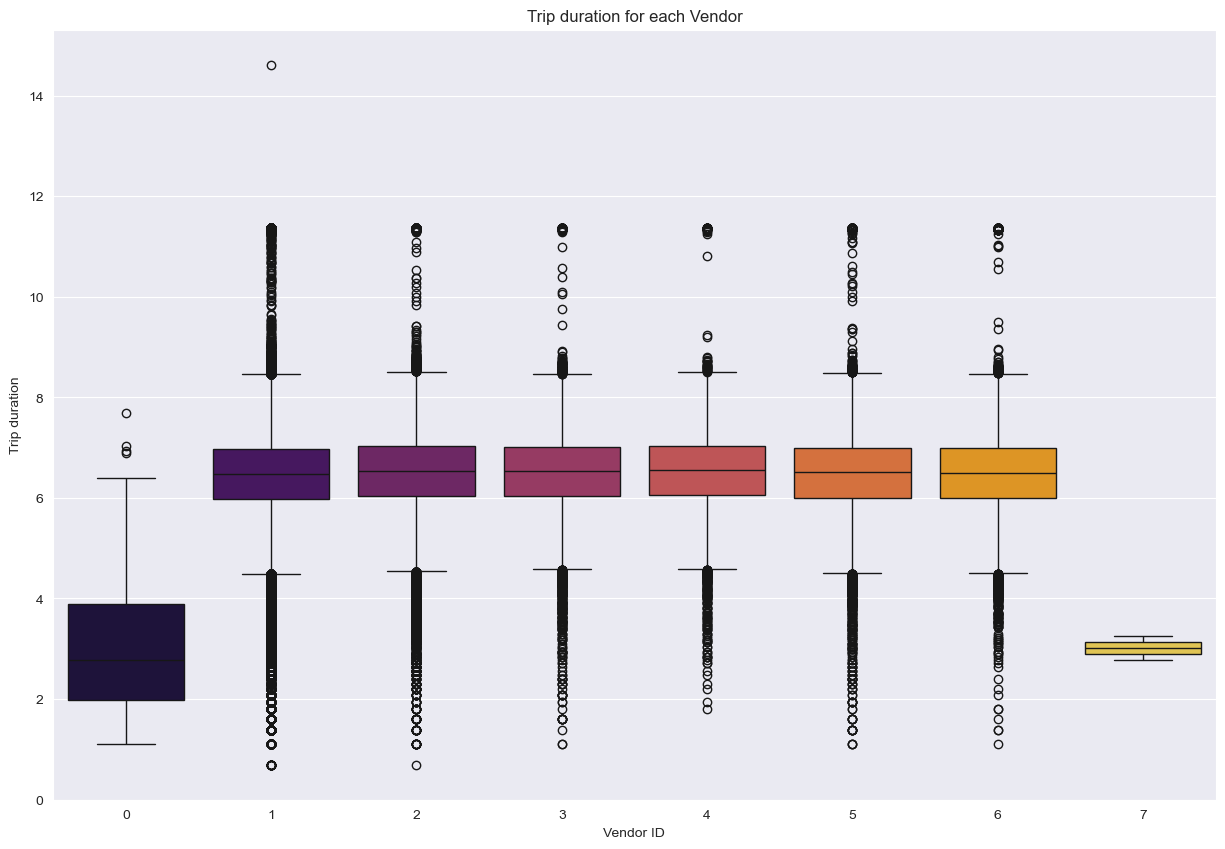

In [33]:
plt.figure(figsize=(15,10))
sns.boxplot(data=data,x='passenger_count',y='log_trip_duration',palette='inferno')
plt.xlabel('Vendor ID')
plt.ylabel('Trip duration')
plt.title('Trip duration for each Vendor')
plt.show()

In [34]:
med = data.groupby('passenger_count')['trip_duration'].mean()
med

passenger_count
0     184.789474
1     925.023671
2     996.547652
3    1030.274651
4    1053.786055
5    1072.365526
6    1071.311894
7      20.000000
Name: trip_duration, dtype: float64

We can observe that an increase in passenger count tends to increase trip duration.

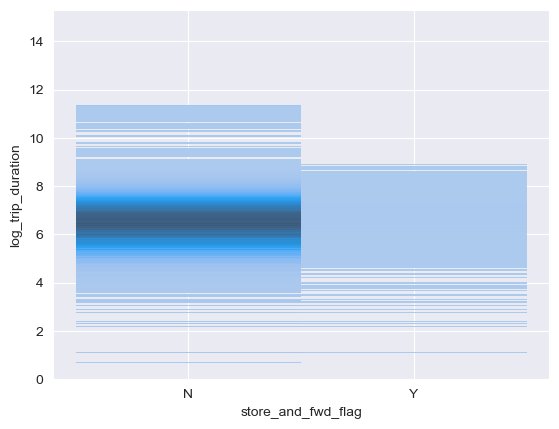

In [35]:
sns.histplot(data=data,x='store_and_fwd_flag',y='log_trip_duration')
plt.show()

In [36]:
data.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration',
       'log_trip_duration', 'month', 'day', 'quarter', 'minute', 'hour',
       'day_name', 'day_period', 'season', 'weekend', 'is_rush_hour'],
      dtype='object')

In [37]:
def haversine(row):
    pick = (row['pickup_latitude'], row['pickup_longitude'])
    drop = (row['dropoff_latitude'], row['dropoff_longitude'])
    dist = geodesic(pick, drop).km
    return dist

data['distance'] = data.apply(haversine,axis=1)
data['distance']

0          2.759702
1          1.959062
2          1.407727
3          1.976073
4         20.861805
            ...    
999995     1.671500
999996     1.977616
999997     1.669837
999998     6.283094
999999     3.461050
Name: distance, Length: 1000000, dtype: float64

In [38]:
(data['distance'] == 0 ).sum()

4085

`We have a distances of zero that should be removed`

In [39]:
# we can extract the speed
data['speed'] = data['distance'] / (data['trip_duration'] / 3600)

In [40]:
#sns.histplot(data=data,x='speed',kde=True)
#plt.show()
((data['speed'] >30).sum() / (data['speed']).count()) * 100

4.627400000000001

<Axes: >

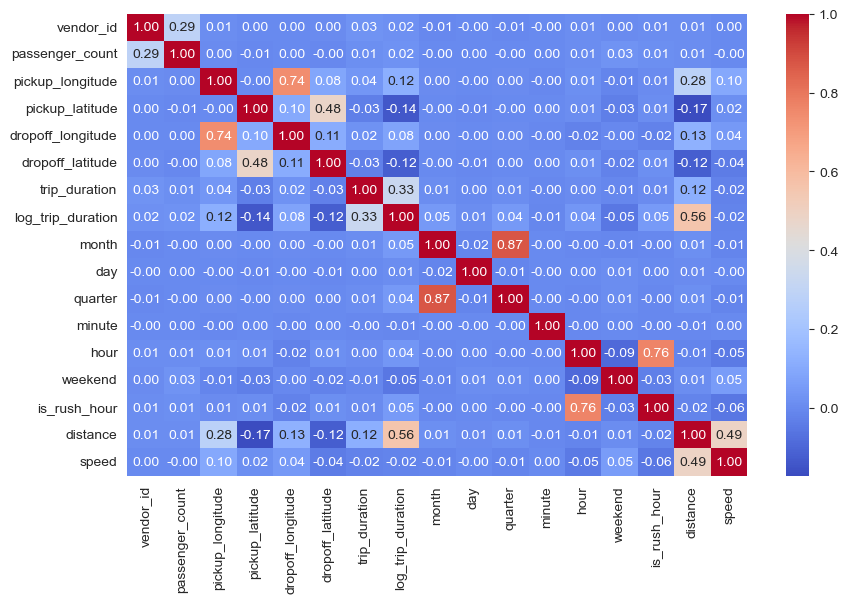

In [41]:
corr = data.corr(numeric_only=True)
plt.figure(figsize=(10,6))
sns.heatmap(corr,annot=True,  cmap="coolwarm", fmt=".2f")

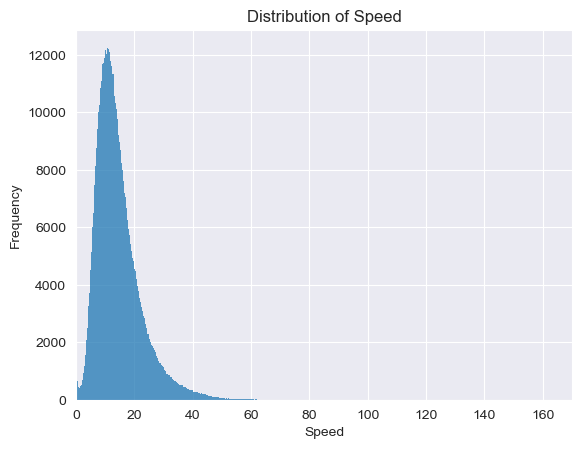

In [42]:
sns.histplot(data['speed'])
plt.xlim(0, 170)
plt.xlabel('Speed')
plt.ylabel('Frequency')
plt.title('Distribution of Speed')
plt.show()

We can notice that most of the trips speed is under 40km/h and the peek is around 10.

In [43]:
print('Median Speed:',data['speed'].median())
print('Mean Speed:',data['speed'].mean())
print('Standard deviation:',data['speed'].std())
print('Max Speed',data['speed'].max())
print('Min Speed',data['speed'].min())
print('Number of speed above 60:',(data['speed'] > 60).sum())

Median Speed: 12.789282788998829
Mean Speed: 14.43125000037855
Standard deviation: 16.578900142662345
Max Speed 9279.581772850921
Min Speed 0.0
Number of speed above 60: 469


Max speed 9279 is not logical the outliers should be handeld

In [44]:
data.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration',
       'log_trip_duration', 'month', 'day', 'quarter', 'minute', 'hour',
       'day_name', 'day_period', 'season', 'weekend', 'is_rush_hour',
       'distance', 'speed'],
      dtype='object')

In [45]:
df = data.copy() 
df['estimated_time_sec_log'] = np.log1p(df['distance'] / 12.78 * 3600) 
data['estimated_time_sec_log'] = df['estimated_time_sec_log']

We notice the high correlation between estimated time and log trip duration

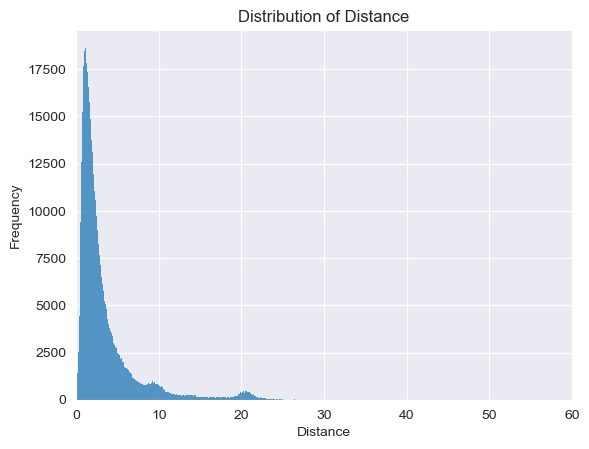

In [46]:
sns.histplot(data['distance'])
plt.xlim(0, 60)
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('Distribution of Distance')
plt.show()

In [47]:
#some distance statistics
print('Number of values above 50Km',(df['distance'] > 50).sum())
print('Standrd deviation: ',(df['distance'].std()))
print('Min Distance: ',(df['distance'].min()))
print('Max Distance: ',(df['distance'].max()))
print('Mean Distance: ',(df['distance'].mean()))
print('Median Distance: ',(df['distance'].median()))

Number of values above 50Km 66
Standrd deviation:  4.4280060376947
Min Distance:  0.0
Max Distance:  1240.5102556291924
Mean Distance:  3.4404287083077603
Median Distance:  2.0917109745465767


In [48]:
data.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration',
       'log_trip_duration', 'month', 'day', 'quarter', 'minute', 'hour',
       'day_name', 'day_period', 'season', 'weekend', 'is_rush_hour',
       'distance', 'speed', 'estimated_time_sec_log'],
      dtype='object')

<Axes: >

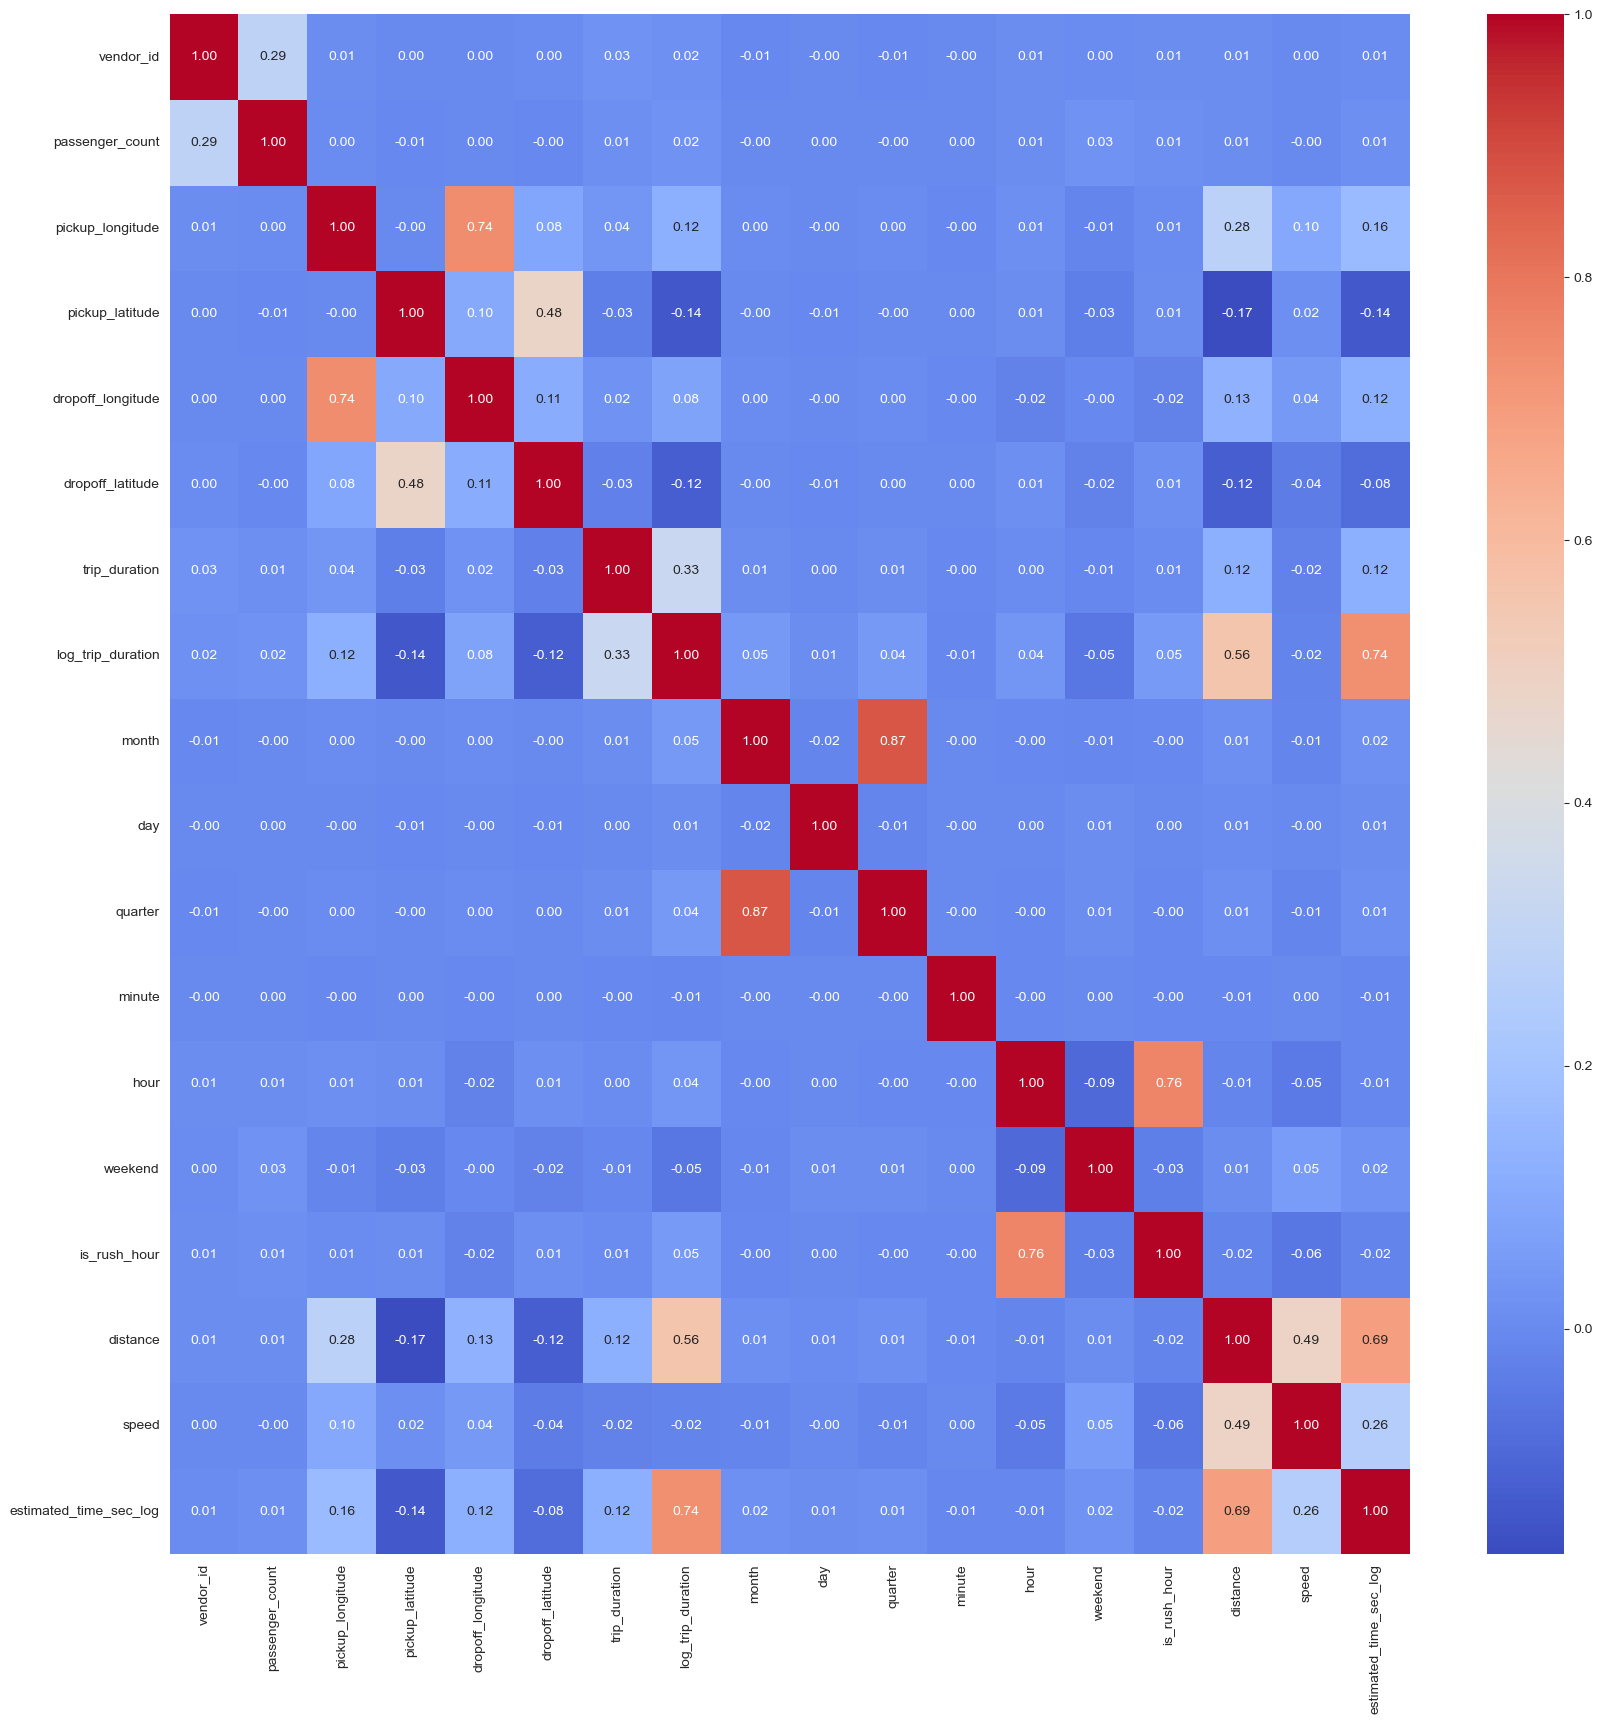

In [49]:
corr = df.corr(numeric_only=True)
plt.figure(figsize=(20,20))
sns.heatmap(corr,annot=True,  cmap="coolwarm", fmt=".2f")

In [50]:
df = data.copy()
geod = pyproj.Geod(ellps='WGS84')
df['bearing'] = (geod.inv(df['pickup_longitude'], df['pickup_latitude'], 
                         df['dropoff_longitude'], df['dropoff_latitude'])[0] + 360) % 360
df['bearing']

0           9.296235
1         214.771146
2          70.152005
3         357.701472
4         306.872883
             ...    
999995     14.958952
999996     39.014781
999997    144.694385
999998    198.391958
999999    210.900954
Name: bearing, Length: 1000000, dtype: float64

In [51]:
df['manhattan_distance'] = (abs(df['pickup_longitude'] - df['dropoff_longitude']) + 
                            abs(df['pickup_latitude'] - df['dropoff_latitude']))

<Axes: >

<Figure size 2000x2000 with 0 Axes>

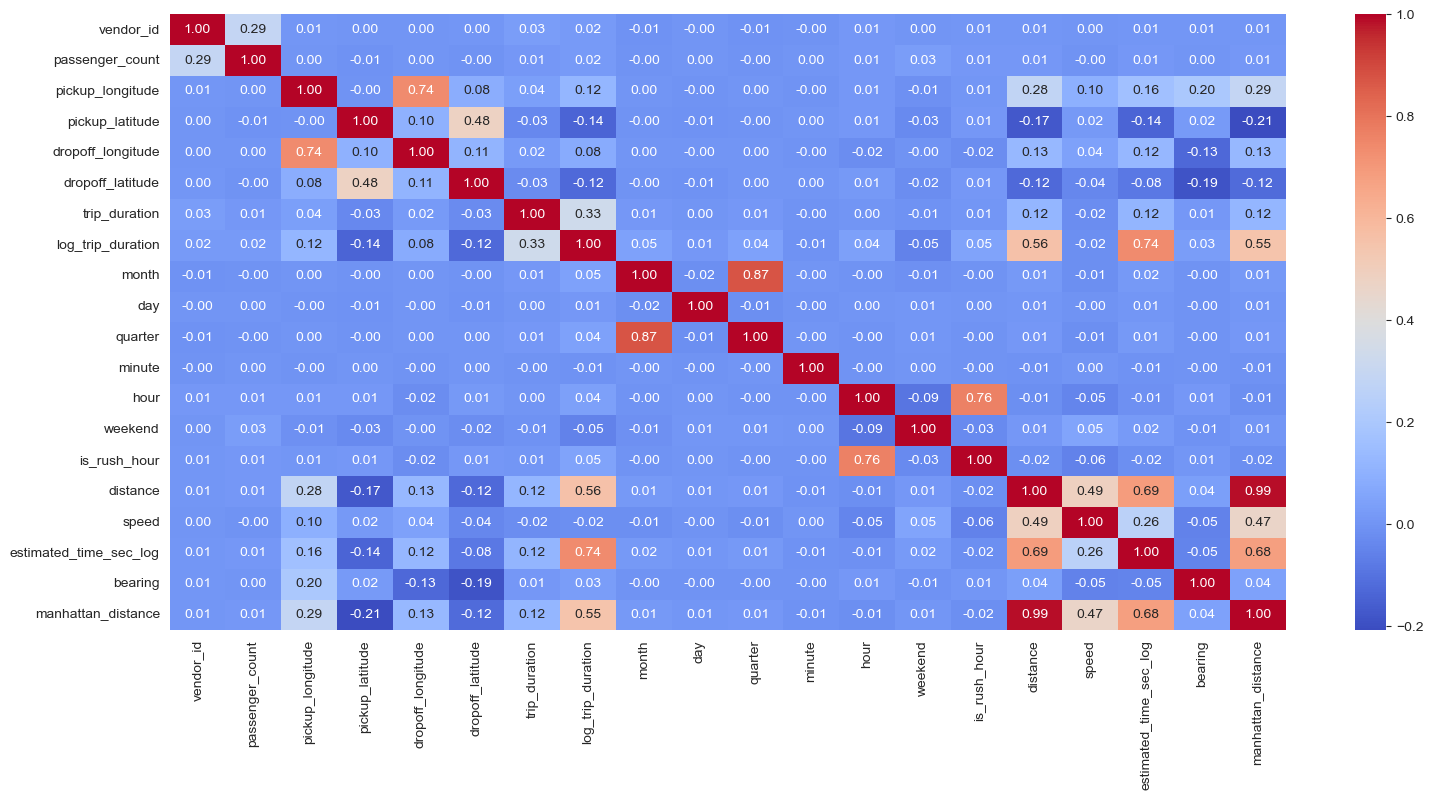

In [52]:
plt.figure(figsize=(20,20))
corr = df.corr(numeric_only=True)
plt.figure(figsize=(18,8))
sns.heatmap(corr,annot=True,  cmap="coolwarm", fmt=".2f")

#### We have made a good EDA and we can start the modelling phase.